In [509]:
import pandas as pd
import numpy as np
import re

#datetime to parse dates
from datetime import datetime
from datetime import date
from datetime import time

# Define the file path (adjust the date string to match your file)
file_path = r"C:\Users\Kaity\Desktop\SchoolActivityDays\SANrawdata_2025-08-25.csv"

# Load the CSV into a DataFrame
sport_calendar_df = pd.read_csv(file_path)

# Quick checks
print(sport_calendar_df.shape)
print(sport_calendar_df.head())


(5026, 4)
          Sport        Date    Time                 School
0          Golf  2024-08-05     TBD  Riverbend High School
1          Golf  2024-08-07     TBD  Riverbend High School
2          Golf  2024-08-14  4:00pm  Riverbend High School
3  Field Hockey  2024-08-14  5:00pm  Riverbend High School
4  Field Hockey  2024-08-14  6:30pm  Riverbend High School


In [511]:
import os

# Set working directory to folder
os.chdir(r"C:\Users\Kaity\Desktop\SchoolActivityDays")

# Confirm it's set correctly
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\Kaity\Desktop\SchoolActivityDays


In [513]:
# Make sure the 'date' column is in datetime format
sport_calendar_df['Date'] = pd.to_datetime(sport_calendar_df['Date'])

# Create a new column with the day of the week (e.g., Monday, Tuesday, etc.)
sport_calendar_df['Weekday'] = sport_calendar_df['Date'].dt.day_name()

# Preview
print(sport_calendar_df[['Date', 'Weekday']].head())

        Date    Weekday
0 2024-08-05     Monday
1 2024-08-07  Wednesday
2 2024-08-14  Wednesday
3 2024-08-14  Wednesday
4 2024-08-14  Wednesday


In [515]:
print(len(sport_calendar_df))

5026


In [517]:
#Explore the dataset
# How many events per school
print("Events per school:")
print(sport_calendar_df['School'].value_counts())

Events per school:
School
Chancellor High School      1989
Courtland High School       1022
Massaponax High School       802
Riverbend High School        653
Spotsylvania High School     560
Name: count, dtype: int64


In [519]:
# Count events per school per sport
school_sport_counts = sport_calendar_df.groupby(['School','Sport']).size().reset_index(name='EventCount')

# Filter just Chancellor
chancellor_sports = school_sport_counts[school_sport_counts['School']=="Chancellor High School"]

print(chancellor_sports.sort_values('EventCount', ascending=False))

                    School                   Sport  EventCount
41  Chancellor High School                Football         151
5   Chancellor High School                Baseball         134
7   Chancellor High School              Basketball         120
88  Chancellor High School                  Tennis         103
44  Chancellor High School        Girls Basketball         101
..                     ...                     ...         ...
65  Chancellor High School                    Prom           1
66  Chancellor High School  Rising 9th grade night           1
16  Chancellor High School    Boys soccer interest           1
69  Chancellor High School          Senior Sunrise           1
0   Chancellor High School                 4E Expo           1

[98 rows x 3 columns]


In [521]:
#WHy so many Chancellor events?
#Look at Chancellor Basketball events
basketball_events = sport_calendar_df[
    (sport_calendar_df['School']=="Chancellor High School") &
    (sport_calendar_df['Sport']=="Basketball")
]

print(basketball_events[['Date','Time','Sport']].head(5))

           Date             Time       Sport
2533 2024-08-17  9:00am - 1:00pm  Basketball
2578 2024-08-24  9:00am - 1:00pm  Basketball
2627 2024-08-31  9:00am - 1:00pm  Basketball
2674 2024-09-07  9:00am - 1:00pm  Basketball
2723 2024-09-14  9:00am - 1:00pm  Basketball


In [523]:
# Remove events with time ranges longer than 2 hours (likely practices, not games)
def filter_events(df):
    # Split on " - " if it's a range
    def duration_hours(time_str):
        if pd.isna(time_str): 
            return None
        if " - " not in time_str:
            return 0  # single time = keep
        try:
            start, end = time_str.split(" - ")
            start = pd.to_datetime(start, format="%I:%M%p")
            end = pd.to_datetime(end, format="%I:%M%p")
            # Handle overnight times (rare, but just in case)
            if end < start:
                end += pd.Timedelta(days=1)
            return (end - start).seconds / 3600
        except Exception:
            return None
    
    df = df.copy()
    df["_duration_hours"] = df["Time"].apply(duration_hours)
    
    # Keep rows with duration <= 3, or single-time events (duration = 0)
    filtered = df[(df["_duration_hours"].notna()) & (df["_duration_hours"] <= 3)]
    
    return filtered.drop(columns=["_duration_hours"])

# Apply this function to the sport calendar df
filtered_calendar = filter_events(sport_calendar_df)

In [524]:
len(filtered_calendar)

4581

In [527]:
# Remove duplicates on key columns
games_only = filtered_calendar.drop_duplicates(subset=['School','Date','Time','Sport'])

len(games_only)

3934

In [529]:
sport_calendar_df = games_only

In [531]:
len(sport_calendar_df)

3934

In [533]:
basketball_events = sport_calendar_df[
    (sport_calendar_df['School']=="Chancellor High School") &
    (sport_calendar_df['Sport']=="Basketball")
]

print(basketball_events[['Date','Time','Sport']].head(5))

           Date    Time       Sport
3151 2024-11-18  5:00pm  Basketball
3153 2024-11-18  6:30pm  Basketball
3181 2024-11-22  6:00pm  Basketball
3183 2024-11-22  7:15pm  Basketball
3184 2024-11-22  7:30pm  Basketball


In [535]:
print("Events per school:")
print(sport_calendar_df['School'].value_counts())

Events per school:
School
Chancellor High School      1685
Courtland High School        639
Massaponax High School       633
Riverbend High School        538
Spotsylvania High School     439
Name: count, dtype: int64


In [537]:
# Count events per school per sport
school_sport_counts = sport_calendar_df.groupby(['School','Sport']).size().reset_index(name='EventCount')

# Filter just Chancellor
chancellor_sports = school_sport_counts[school_sport_counts['School']=="Chancellor High School"]

print(chancellor_sports.sort_values('EventCount', ascending=False))

                    School                                  Sport  EventCount
28  Chancellor High School                               Football         149
4   Chancellor High School                               Baseball         132
31  Chancellor High School                       Girls Basketball         100
69  Chancellor High School                             Volleyball          93
9   Chancellor High School                        Boys Basketball          90
..                     ...                                    ...         ...
37  Chancellor High School  Harrison Road ES Husky 1/2 mile event           1
24  Chancellor High School             Fall Sports Awards Banquet           1
33  Chancellor High School                  Girls Soccer Interest           1
26  Chancellor High School            Field Hockey Awards Banquet           1
36  Chancellor High School                   Hall of Fame Banquet           1

[72 rows x 3 columns]


In [539]:
# List of allowed sport keywords (substrings) - removing extra events
allowed_sports = [
    "Golf", "Field Hockey", "Football", "Volleyball", "Sideline Cheer Fall", 
    "Cross Country", "Competition Cheer", "Basketball", "Wrestling", 
    "Swim & Dive", "Indoor Track", "Lacrosse", "Tennis", "Softball", 
    "Baseball", "Soccer", "Outdoor Track", "Swim", 
    "Girls Soccer", "Girls Basketball", "Girls Lacrosse", 
    "Boys Soccer", "Boys Lacrosse", "Boys Basketball"
]

# Build regex pattern from keywords
pattern = '|'.join(allowed_sports)

# Keep only rows where Sport contains one of the allowed substrings
sport_calendar_df = sport_calendar_df[sport_calendar_df['Sport'].str.contains(pattern, case=False, na=False)]

# Reset index for cleanliness
sport_calendar_df = sport_calendar_df.reset_index(drop=True)

#Ban more events, such as those for middle school or other leagues, that aren't relevant to our question
#List of "sports" to exclude
ban_list = [
    "Seniors vs Staff Basketball Game",
    "Soccer Officials",
    "American Youth Football (AYF) - Games",
    "Soccer Tots",
    "Middle School Football Championship Game",
    "Middle School Football Game",
    "VAYFA - Youth Football Games",
    "Virginia Jags - Youth Football Games",
    "SCPS Middle School Football Semi-Final",
    "POMS Football",
        
]
ban_pattern = re.compile("|".join(re.escape(x) for x in ban_list), flags=re.IGNORECASE)


# apply filter (assuming column is called 'Sport' or 'Event')
col_to_check = 'Sport' if 'Sport' in sport_calendar_df.columns else 'Event'

# keep only rows that do NOT match the banned list
sport_calendar_df = sport_calendar_df[
    ~sport_calendar_df[col_to_check].astype(str).str.contains(ban_pattern, na=False)
]

#Simplify Sport column values so they just say the sport, no extra words

df = sport_calendar_df.copy()

# Define the canonical sports we want to keep
canonical_sports = [
    "Golf", "Field Hockey", "Football", "Volleyball", "Sideline Cheer Fall",
    "Cross Country", "Competition Cheer", "Basketball", "Wrestling",
    "Swim & Dive", "Indoor Track", "Lacrosse", "Tennis",
    "Softball", "Baseball", "Soccer", "Outdoor Track", "Swim",
    "Girls Soccer", "Girls Basketball", "Boys Soccer", "Boys Basketball",
    "Girls Lacrosse", "Boys Lacrosse"
]

# Make a regex mapping (search keywords -> canonical name)
mapping = {
    r"golf": "Golf",
    r"field hockey": "Field Hockey",
    r"football": "Football",
    r"volleyball": "Volleyball",
    r"sideline cheer": "Sideline Cheer Fall",
    r"cross country": "Cross Country",
    r"competition cheer": "Competition Cheer",
    r"basketball": "Basketball",
    r"wrestling": "Wrestling",
    r"swim": "Swim & Dive",
    r"indoor track": "Indoor Track",
    r"lacrosse": "Lacrosse",
    r"tennis": "Tennis",
    r"softball": "Softball",
    r"baseball": "Baseball",
    r"soccer": "Soccer",
    r"outdoor track": "Outdoor Track",
}

# Function to normalize one sport string
def normalize_sport(value):
    val = str(value).lower()
    for pattern, replacement in mapping.items():
        if re.search(pattern, val):
            return replacement
    return value  # keep original if no match

df['Sport'] = df['Sport'].apply(normalize_sport)

# Check results
print(df['Sport'].unique())

['Golf' 'Field Hockey' 'Football' 'Volleyball' 'Sideline Cheer Fall'
 'Cross Country' 'Competition Cheer' 'Basketball' 'Wrestling'
 'Swim & Dive' 'Indoor Track' 'Lacrosse' 'Tennis' 'Softball' 'Baseball'
 'Soccer' 'Outdoor Track']


In [541]:
print(len(df))

3322


In [543]:
#Merge back to main branch
sport_calendar_df = df

In [545]:
# Convert "4:00pm" strings to datetime.time
sport_calendar_df['Time_dt'] = pd.to_datetime(
    sport_calendar_df['Time'], format='%I:%M%p', errors='coerce'
).dt.time


In [547]:
#Explore the dataset
# How many events per school
print("Events per school:")
print(sport_calendar_df['School'].value_counts())

Events per school:
School
Chancellor High School      1401
Massaponax High School       535
Riverbend High School        528
Courtland High School        449
Spotsylvania High School     409
Name: count, dtype: int64


In [549]:
#Why does Chancellor still have so many events?

# Count events per school per sport
school_sport_counts = sport_calendar_df.groupby(['School','Sport']).size().reset_index(name='EventCount')

# Filter just Chancellor
chancellor_sports = school_sport_counts[school_sport_counts['School']=="Chancellor High School"]

print(chancellor_sports.sort_values('EventCount', ascending=False))


                    School              Sport  EventCount
1   Chancellor High School         Basketball         260
9   Chancellor High School             Soccer         187
5   Chancellor High School           Football         151
0   Chancellor High School           Baseball         133
13  Chancellor High School         Volleyball          93
4   Chancellor High School       Field Hockey          89
12  Chancellor High School             Tennis          78
10  Chancellor High School           Softball          77
14  Chancellor High School          Wrestling          73
7   Chancellor High School       Indoor Track          71
3   Chancellor High School      Cross Country          68
11  Chancellor High School        Swim & Dive          61
6   Chancellor High School               Golf          44
8   Chancellor High School      Outdoor Track          14
2   Chancellor High School  Competition Cheer           2


In [551]:
#We still have basketball events showing up outside of basketball season, and that may be true for other sports as well, so we're going to define the sport seasons, and remove all events that are outside that season.

#start with a copy of the dataframe
df = sport_calendar_df.copy()

# --- 1) Parse the event date ---
# Replace 'Date' below with your actual date column if different.

df['EventDate'] = pd.to_datetime(df['Date'], errors='coerce')

# --- 3) Define season windows (inclusive) ---
# Dates given for Fredericksburg area 2024–25 seasons.
# Use precise dates you provided; "~" dates set to concrete start dates below.
seasons = {
    'Competition Cheer': ('2024-07-31', '2024-11-10'),
    'Field Hockey':      ('2024-08-04', '2024-11-10'),
    'Football':          ('2024-07-31', '2024-12-15'),
    'Volleyball':        ('2024-08-04', '2024-11-30'),
    'Basketball':        ('2024-11-11', '2025-03-30'),
    'Swim & Dive':       ('2024-11-11', '2025-02-22'),
    'Wrestling':         ('2024-11-11', '2025-02-22'),
    'Baseball':          ('2025-02-24', '2025-06-14'),
    'Softball':          ('2025-02-24', '2025-06-14'),
    'Soccer':            ('2025-02-24', '2025-06-14'),
    # Newly requested sports:
    'Golf':              ('2024-07-29', '2024-10-15'),
    # Sideline cheer spans football & basketball seasons; adjust if you split by season.
    'Sideline Cheer':    ('2024-08-01', '2025-03-30'),
    'Cross Country':     ('2024-08-05', '2024-11-16'),
    'Indoor Track':      ('2024-11-11', '2025-03-06'),

    # As requested: start Mar 1, end mid-May
    'Lacrosse':          ('2025-03-01', '2025-05-15'),
    'Tennis':            ('2025-03-01', '2025-05-15'),
    'Outdoor Track':     ('2025-03-01', '2025-05-15'),
}

seasons_df = (
    pd.DataFrame.from_dict(seasons, orient='index', columns=['season_start', 'season_end'])
      .rename_axis('Sport')
      .reset_index()
)
seasons_df['season_start'] = pd.to_datetime(seasons_df['season_start'])
seasons_df['season_end']   = pd.to_datetime(seasons_df['season_end'])

# --- 4) Join seasons onto events ---
df = df.merge(seasons_df, on='Sport', how='left')

# --- 5) Keep only events that fall within the sport’s season window ---
# This automatically excludes Open Gym (or any event type) if it lands outside the season dates,
# while keeping practices/games/etc. that are in-season.
in_season_mask = (
    df['EventDate'].notna()
    & df['season_start'].notna()
    & df['season_end'].notna()
    & df['EventDate'].between(df['season_start'], df['season_end'], inclusive='both')
)

filtered_df = df.loc[in_season_mask].copy()


print(f"Original rows: {len(df)}")
print(f"Kept rows (in-season only): {len(filtered_df)}")
print(f"Dropped rows (out-of-season or unrecognized sport/date): {len(df) - len(filtered_df)}")

Original rows: 3322
Kept rows (in-season only): 2977
Dropped rows (out-of-season or unrecognized sport/date): 345


In [553]:
#Merge the filtered df back into the main branch
sport_calendar_df = filtered_df

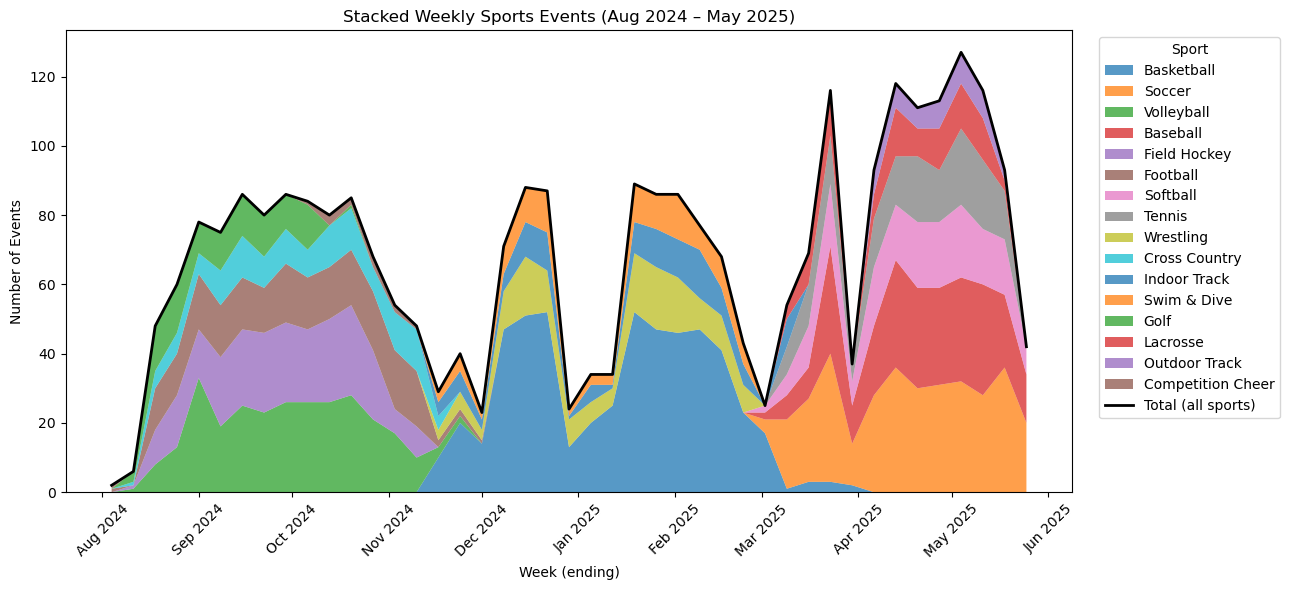

In [555]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.patches import Patch

# ---- Inputs you can tweak ----
START = "2024-08-01"
END   = "2025-05-31"
WEEK_FREQ = "W-SUN"   # week ends on Sunday. Alternatives: "W-SAT", "W-MON", etc.

# ---- 1) Ensure datetime ----
df = sport_calendar_df.copy()
df['EventDate'] = pd.to_datetime(df['EventDate'], errors='coerce')

# ---- 2) Weekly counts per sport ----
weekly_counts = (
    df
    .groupby([pd.Grouper(key='EventDate', freq=WEEK_FREQ), 'Sport'])
    .size()
    .reset_index(name='count')
)

pivot = weekly_counts.pivot(index='EventDate', columns='Sport', values='count').fillna(0)

# ---- 3) Ensure every week in the range appears (even if zero) ----
weekly_index = pd.date_range(start=START, end=END, freq=WEEK_FREQ)
pivot = pivot.reindex(weekly_index, fill_value=0)

# Optional: order sports by total volume (largest first looks nicer in stacks)
sport_order = pivot.sum(axis=0).sort_values(ascending=False).index.tolist()
pivot = pivot[sport_order]

# ---- 4) Plot stacked weekly area + total line ----
x = pivot.index
y = pivot.T.values  # (n_sports, n_weeks)

plt.figure(figsize=(13, 6))

# Stacked areas (matplotlib assigns distinct colors)
stack_handles = plt.stackplot(x, y, labels=pivot.columns, alpha=0.75)

# Total line
total = pivot.sum(axis=1)
plt.plot(x, total, linewidth=2, label='Total (all sports)', color='black')

# Title/labels
plt.title("Stacked Weekly Sports Events (Aug 2024 – May 2025)")
plt.xlabel("Week (ending)")
plt.ylabel("Number of Events")

# Month ticks to avoid crowding
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Legend: colored patches per sport + total line
area_patches = [Patch(facecolor=h.get_facecolor()[0], label=lbl) for h, lbl in zip(stack_handles, pivot.columns)]
total_line = plt.Line2D([0], [0], linewidth=2, color='black', label='Total (all sports)')
plt.legend(handles=area_patches + [total_line], title="Sport", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()



In [557]:
#Filter out events that are earlier in the day and won't affect youth group attendance
df = sport_calendar_df.copy()

# Split on "-" in case of ranges like "5:30pm - 7:00pm"
time_split = df['Time'].str.split('-', n=1, expand=True)

# Parse start and end separately
df['Start_dt'] = pd.to_datetime(time_split[0].str.strip(),
                                format='%I:%M%p', errors='coerce').dt.time
df['End_dt'] = pd.to_datetime(time_split[1].str.strip(),
                              format='%I:%M%p', errors='coerce').dt.time

# Build mask:
#   - keep rows where start is after 5:00 PM OR end is before 6:00 PM
#   - keep TBD (NaT) too if you want
mask = (
    df['Start_dt'].isna() |
    (df['Start_dt'] > time(17,0)) |
    (df['End_dt'] < time(18,0))
)

filtered_df = df.loc[mask]

print(f"Original rows: {len(df)}")
print(f"Kept rows after filtering (end <6pm or start >5pm or TBD): {len(filtered_df)}")

Original rows: 2977
Kept rows after filtering (end <6pm or start >5pm or TBD): 2020


In [559]:
mask = filtered_df['Start_dt'].isna() | (filtered_df['Start_dt'] > time(17,0))
filtered_df2 = filtered_df.loc[mask]

print(f"Original rows: {len(filtered_df)}")
print(f"Kept rows after filtering >5pm or TBD): {len(filtered_df2)}")

Original rows: 2020
Kept rows after filtering >5pm or TBD): 1445


In [561]:
df = filtered_df2.copy()

df['ParsedTime'] = pd.to_datetime(df['Time'], format='%I:%M%p', errors='coerce')
df['Hour'] = df['ParsedTime'].dt.hour

sport_evenings_df = df

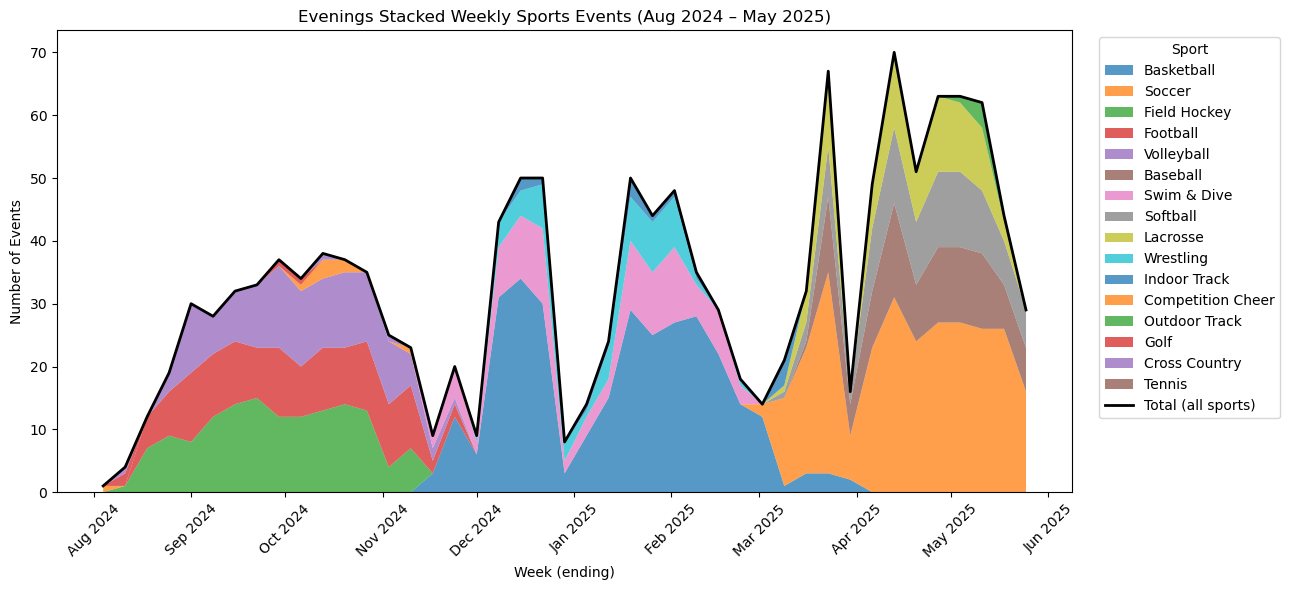

In [564]:

# ---- Inputs you can tweak ----
START = "2024-08-01"
END   = "2025-05-31"
WEEK_FREQ = "W-SUN"   # week ends on Sunday. Alternatives: "W-SAT", "W-MON", etc.

# ---- 1) Ensure datetime ----
# Assumes you already have a filtered_df from the season filter and a 'Sport' column
df = sport_evenings_df.copy()
df['EventDate'] = pd.to_datetime(df['EventDate'], errors='coerce')

# ---- 2) Weekly counts per sport ----
weekly_counts = (
    df
    .groupby([pd.Grouper(key='EventDate', freq=WEEK_FREQ), 'Sport'])
    .size()
    .reset_index(name='count')
)

pivot = weekly_counts.pivot(index='EventDate', columns='Sport', values='count').fillna(0)

# ---- 3) Ensure every week in the range appears (even if zero) ----
weekly_index = pd.date_range(start=START, end=END, freq=WEEK_FREQ)
pivot = pivot.reindex(weekly_index, fill_value=0)

# Optional: order sports by total volume (largest first looks nicer in stacks)
sport_order = pivot.sum(axis=0).sort_values(ascending=False).index.tolist()
pivot = pivot[sport_order]

# ---- 4) Plot stacked weekly area + total line ----
x = pivot.index
y = pivot.T.values  # (n_sports, n_weeks)

plt.figure(figsize=(13, 6))

# Stacked areas (matplotlib assigns distinct colors)
stack_handles = plt.stackplot(x, y, labels=pivot.columns, alpha=0.75)

# Total line
total = pivot.sum(axis=1)
plt.plot(x, total, linewidth=2, label='Total (all sports)', color='black')

# Title/labels
plt.title("Evenings Stacked Weekly Sports Events (Aug 2024 – May 2025)")
plt.xlabel("Week (ending)")
plt.ylabel("Number of Events")

# Month ticks to avoid crowding
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Legend: colored patches per sport + total line
area_patches = [Patch(facecolor=h.get_facecolor()[0], label=lbl) for h, lbl in zip(stack_handles, pivot.columns)]
total_line = plt.Line2D([0], [0], linewidth=2, color='black', label='Total (all sports)')
plt.legend(handles=area_patches + [total_line], title="Sport", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [566]:
sport_calendar_df = sport_calendar_df.drop(['Date', 'Time', 'season_start', 'season_end'], axis =1)

In [570]:

# Create a df of Average roster sizes for various high school sports for similar school sizes in virginia

avg_roster_va = {
    "Golf": 10,
    "Field Hockey": 22,
    "Football": 55,
    "Volleyball": 12,
    "Competition Cheer": 18,
    "Basketball": 12,
    "Wrestling": 24,
    "Swim & Dive": 30,
    "Lacrosse": 24,
    "Tennis": 12,
    "Softball": 14,
    "Baseball": 18,
    "Soccer": 20,
    "Outdoor Track": 60,
    "Indoor Track": 50,
    "Cross Country": 50,
}

df = sport_calendar_df.copy()

# Add the average participants column based on the Sport value
df["Participants"] = df["Sport"].map(avg_roster_va).astype("float")

# quick check for any sports that weren't mapped
unmapped = sorted(set(df["Sport"]) - set(avg_roster_va.keys()))
if unmapped:
    print("Unmapped sports (update avg_roster_va if needed):", unmapped)

sport_calendar_df = df

In [574]:
print(sport_calendar_df.columns)


Index(['Sport', 'School', 'Weekday', 'Time_dt', 'EventDate', 'Participants'], dtype='object')


In [576]:
# Set output folder
output_folder = r"C:\Users\Kaity\Desktop\SchoolActivityDays"

# Save your main cleaned dataframe
sport_calendar_df.to_csv(f"{output_folder}\\SANcleaned.csv", index=False)



print("Files saved successfully!")

Files saved successfully!


In [578]:
print(sport_evenings_df.columns)

Index(['Sport', 'Date', 'Time', 'School', 'Weekday', 'Time_dt', 'EventDate',
       'season_start', 'season_end', 'Start_dt', 'End_dt', 'ParsedTime',
       'Hour'],
      dtype='object')


In [582]:
sport_evenings_df = sport_evenings_df.drop(['Date', 'Time', 'season_start', 'season_end', 'Start_dt', 'End_dt', 'ParsedTime', 'Hour'], axis =1)

In [584]:
# Set output folder
output_folder = r"C:\Users\Kaity\Desktop\SchoolActivityDays"

# Save your main cleaned dataframe
sport_evenings_df.to_csv(f"{output_folder}\\Evenings_SANcleaned.csv", index=False)



print("Files saved successfully!")

Files saved successfully!
